In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df_teams = pd.DataFrame(teams.get_teams())
team_id_list = list(df_teams.id)

In [3]:
#finding MIN game with the most 3pts shots taken by Malik:
df_gameid = shotchartdetail.ShotChartDetail(team_id = 1610612750, player_id = 1627736).get_data_frames()[0]
df_gameid[df_gameid.GAME_DATE == '20220309']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
657,Shot Chart Detail,0022100986,11,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,11,12,Made Shot,Step Back Jump shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,24,232,75,1,1,20220309,MIN,OKC
658,Shot Chart Detail,0022100986,68,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,5,12,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,38,243,1,1,20220309,MIN,OKC
659,Shot Chart Detail,0022100986,77,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,4,14,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,56,242,1,1,20220309,MIN,OKC
660,Shot Chart Detail,0022100986,124,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,1,34,Made Shot,Running Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-225,9,1,1,20220309,MIN,OKC
661,Shot Chart Detail,0022100986,128,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,54,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-65,237,1,1,20220309,MIN,OKC
662,Shot Chart Detail,0022100986,131,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,16,Made Shot,Step Back Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,61,1,1,20220309,MIN,OKC
663,Shot Chart Detail,0022100986,287,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,3,21,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-224,-11,1,1,20220309,MIN,OKC
664,Shot Chart Detail,0022100986,366,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,3,8,9,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,195,157,1,1,20220309,MIN,OKC
665,Shot Chart Detail,0022100986,395,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,3,6,2,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-172,185,1,1,20220309,MIN,OKC
666,Shot Chart Detail,0022100986,533,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,4,7,31,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-169,193,1,1,20220309,MIN,OKC


#### Save the player_id/team_id combo to a csv

In [4]:
filename = 'team_player_ids.csv'
if os.path.isfile(filename):
    team_player_ids =  pd.read_csv(filename, index_col=0)
else:
    players_list = []
    for team in team_id_list:
        df_tpd = teamplayerdashboard.TeamPlayerDashboard(team,
                                                         season = '2021-22').get_data_frames()
        player_list = list(df_tpd[1].PLAYER_ID)
        for player in player_list:
            row = [team,player]
            players_list.append(row)
    team_player_ids = pd.DataFrame(players_list, columns = ['team_id','player_id'])
    team_player_ids.to_csv('team_player_ids.csv')

## Acquiring a dataframe of every shot taken from the 2021-2022 regular NBA season.

In [5]:
players_list = team_player_ids.values.tolist()

In [6]:
"""This function will acquire and cache .csv in notebook directory"""
filename2 = 'all_last_season_shots.csv'
if os.path.isfile(filename2):
    df_all_shots =  pd.read_csv(filename2, index_col=0)
else:
    players_list = []
    df = pd.DataFrame()
    index = 0
    for player in players_list:
        print(f'\rFetching index {index} of 714', end='')
        df_pl = shotchartdetail.ShotChartDetail(team_id = player[0],
                                                        player_id = player[1],
                                                        season_type_all_star='Regular Season',
                                                        season_nullable='2021-22',
                                                        context_measure_simple = 'FG3A').get_data_frames()
        time.sleep(.5)
        index += 1
        #df = pd.concat([df, df_pl[0]])
        #df.to_csv(filename2) these last two lines of code are looping and overwriting the current csv until last time 
        #through the loop.
        
        

## Adding in only 3pt shots into the dataframe:

-We are removing outliers by taking the sum of the lowest and highest quantile and multiplying by 1.5 to create an IQR upper bound (removing the anomaly shots that are opposite court-side and keeping the shots only with the 3pt shot range).

In [7]:
#calling in our df_all_shots dataframe and resetting index:
df_all_shots = df_all_shots.reset_index(drop = True)

In [8]:
#creating a df for only the 3pt shots taken:
df_all_3pt = df_all_shots[df_all_shots.SHOT_TYPE == '3PT Field Goal']

In [9]:
#Creating an IQR upper bound to remove the large anomaly 3pt shots taken.
low = df_all_3pt.SHOT_DISTANCE.quantile(.25)
high = df_all_3pt.SHOT_DISTANCE.quantile(.75)
add = (high-low) * 1.5
bound = high + add
#this is where our bound is:
bound

29.0

In [10]:
#creating our bounds: any thing over 29ft in shot distance is in outliers df:
df_outlier_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE > 29.0]

In [11]:
#anything less than 29 or equal to is now our df_3pt df:
df_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE <= 29.0]

In [12]:
#recreating our main df to only hold those 3pt shots and IQR:
df_shots = df_all_shots[df_all_shots.SHOT_DISTANCE <= 29.0]

### Clustering the 3pt shot locations (once outliers are taken out)

In [13]:
#creating our X variable:
X = df_3pt[['LOC_X','LOC_Y']]

In [14]:
#we found that using 7 kmean clusters gave us not only good 3pt
#area clusters, but also shots made in center court of the arch
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [15]:
#we will add a new column onto our main df to hold these clusters:
df_3pt['three_pt_location'] = clusters

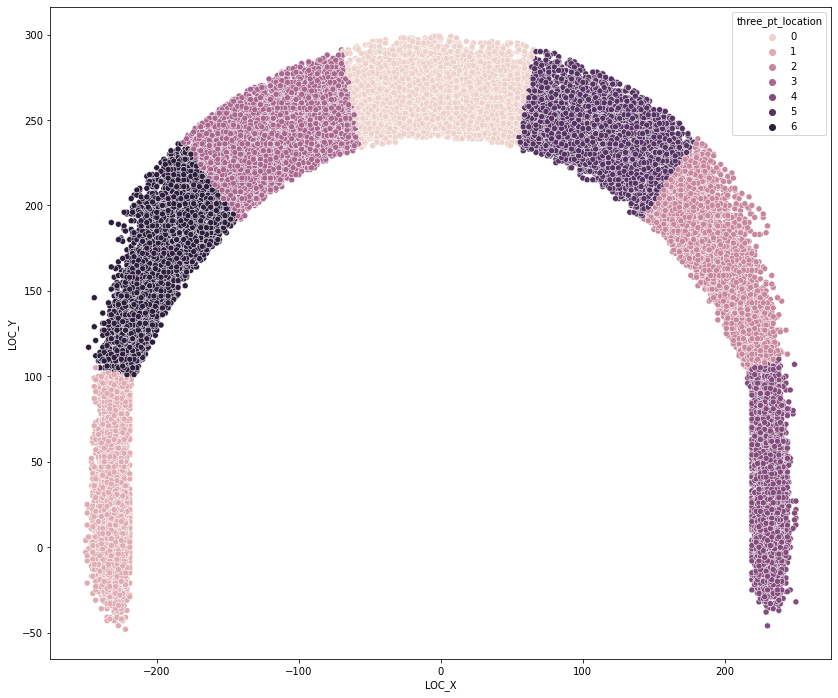

In [16]:
#plotting these 7clusters on the 3pt zone:
plt.figure(figsize = (14,12))
sns.scatterplot(data =df_3pt, x='LOC_X', y = 'LOC_Y', hue = 'three_pt_location')
plt.show()

### We want to have descriptive names of each of these cluster zones. 
We are giving each of these clusters names by map their locations:

In [17]:
# creating a new column with the location names:
df_3pt['location'] = df_3pt['three_pt_location'].map({0: 'R Above Break', 1: 'L Above Break',2:'L Below Break/Corner',3:'R Center',4:'R Below Break/Corner',5:'Center',6:'L Center'})

In [18]:
#creating a variable to use for applying clusters to 3pt only shots
#note: 2pt shots will be NaN
location_column = df_3pt[['location']]

In [19]:
#merging the applying the clusters:
df_shots = df_shots.merge(location_column, how = 'left', left_index = True, right_index = True)

In [20]:
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,location
0,Shot Chart Detail,22100014,42,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,8,14,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,64,1,1,20211021,ATL,DAL,R Below Break/Corner
1,Shot Chart Detail,22100014,47,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,7,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,91,232,1,1,20211021,ATL,DAL,Center
2,Shot Chart Detail,22100014,305,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,2,1,44,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,6,79,1,0,20211021,ATL,DAL,NaN
3,Shot Chart Detail,22100014,362,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,9,40,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,69,1,1,20211021,ATL,DAL,R Below Break/Corner
4,Shot Chart Detail,22100014,433,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,4,24,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,134,210,1,0,20211021,ATL,DAL,Center


## Let's see if this works!
Creating a Test case using the Spurs and Keldon Johnson.

In [28]:
team_id = teams.find_team_by_abbreviation('MIN')['id'] # For Minnesota Timberwolves

player_id = players.find_players_by_full_name("Malik Beasley")[0]['id'] # For Malik Beasley

game_id = '0022100986' # First game of year Spurs vs. Magic - note that game id must be converted to an int in df_shots

In [29]:
team_id

1610612750

### We are using the `win_probability` api endpoint for a base of the analysis dataframe.

In [30]:
# Select for a single game
df_base = winprobabilitypbp.WinProbabilityPBP(game_id).get_data_frames()[0]
df_base

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE
0,0022100986,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:11 PM EST),,12:00,1.0
1,0022100986,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Towns vs. Roby: Tip to Beasley,h,12:00,1.0
2,0022100986,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN
3,0022100986,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN
4,0022100986,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,0022100986,NaN,NaN,NaN,132,102,30,4,4.0,1.0,None,None,None,None,NaN
3017,0022100986,NaN,NaN,NaN,132,102,30,4,3.0,1.0,None,None,None,None,NaN
3018,0022100986,NaN,NaN,NaN,132,102,30,4,2.0,1.0,None,None,None,None,NaN
3019,0022100986,NaN,NaN,NaN,132,102,30,4,1.0,1.0,None,None,None,None,NaN


#### We started with the win_prob endpoint as this houses play-by-play by second/minutes. 
We need to then have a `absolute_time` in game seconds since the play started.

In [31]:
# Utilize user function to create absolute time (in seconds) column
df_base['abs_time'] = np.where(df_base.PERIOD <5,
                     ((df_base.PERIOD - 1) * 720 + (720 - df_base.SECONDS_REMAINING)),
                     (2880 + (df_base.PERIOD - 5) * 300 + (300 - df_base.SECONDS_REMAINING)))

### Adding on the Rotation Dataframe so we can have each players' minutes of play vs rest times.

In [33]:
df_rotation = gamerotation.GameRotation(game_id).get_data_frames()

'Game Rotation' returns all the minutes (play time in the court) for every player in the game, seperated into Home and Visitor Dataframes.  As such we search through players for the records with our player_id.  Returns a dataframe holding their rotational stats, most importantly in_time and out_time.

In [34]:
#for-loop to cycle through the players (by ID) in the rotation df
#to then grab their times:
for i in range(2):
    for player in df_rotation[i].PERSON_ID:
        if player == player_id:
            df_player_roto = df_rotation[i][df_rotation[i].PERSON_ID == player]


We need to convert the rotational time in 1/10ths of second, into seconds, then isolate those times out.

In [35]:
df_player_roto['abs_in_time'] = df_player_roto.IN_TIME_REAL/10
df_player_roto['abs_out_time'] = df_player_roto.OUT_TIME_REAL/10
df_player_roto_times = df_player_roto[['abs_in_time','abs_out_time']].reset_index(drop = 'True')

Using a zip function, we are putting together the in and out times together.

In [36]:
zipped = list(zip(df_player_roto_times.abs_in_time, df_player_roto_times.abs_out_time))

In [37]:
#showing what it looks like now:
zipped

[(0.0, 720.0), (1126.0, 1932.0), (2333.0, 2583.0)]

#### Let's filter out the times of the game (from the df_base of  win_prob) that align with the player's play time.

In [38]:
# Let me create a holder dataframe as I pull slices off from the base
df_player_game = pd.DataFrame()
for tuplez in zipped:
    df_slice = df_base[(df_base.abs_time >= tuplez[0]) & (df_base.abs_time <= tuplez[1])]
    df_player_game = pd.concat([df_player_game, df_slice])
df_player_game

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100986,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:11 PM EST),,12:00,1.0,0.0
1,0022100986,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Towns vs. Roby: Tip to Beasley,h,12:00,1.0,0.0
2,0022100986,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1.0
3,0022100986,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2.0
4,0022100986,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0022100986,579.0,NaN,NaN,120,91,29,4,297.0,0.0,None,Wiggins Free Throw 1 of 2 (24 PTS),v,4:57,1.0,2583.0
2706,0022100986,580.0,NaN,NaN,120,91,29,4,297.0,0.0,None,SUB: Bolmaro FOR McDaniels,h,4:57,1.0,2583.0
2707,0022100986,581.0,NaN,NaN,120,91,29,4,297.0,0.0,None,SUB: Okogie FOR Beasley,h,4:57,1.0,2583.0
2708,0022100986,584.0,NaN,NaN,120,92,28,4,297.0,1.0,None,Wiggins Free Throw 2 of 2 (25 PTS),v,4:57,1.0,2583.0


In [39]:
#testing this out:
df_test = df_player_game.copy()
df_test

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100986,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:11 PM EST),,12:00,1.0,0.0
1,0022100986,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Towns vs. Roby: Tip to Beasley,h,12:00,1.0,0.0
2,0022100986,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1.0
3,0022100986,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2.0
4,0022100986,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0022100986,579.0,NaN,NaN,120,91,29,4,297.0,0.0,None,Wiggins Free Throw 1 of 2 (24 PTS),v,4:57,1.0,2583.0
2706,0022100986,580.0,NaN,NaN,120,91,29,4,297.0,0.0,None,SUB: Bolmaro FOR McDaniels,h,4:57,1.0,2583.0
2707,0022100986,581.0,NaN,NaN,120,91,29,4,297.0,0.0,None,SUB: Okogie FOR Beasley,h,4:57,1.0,2583.0
2708,0022100986,584.0,NaN,NaN,120,92,28,4,297.0,1.0,None,Wiggins Free Throw 2 of 2 (25 PTS),v,4:57,1.0,2583.0


In [40]:
df_player_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 2709
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GAME_ID            1863 non-null   object 
 1   EVENT_NUM          281 non-null    float64
 2   HOME_PCT           1852 non-null   float64
 3   VISITOR_PCT        1852 non-null   float64
 4   HOME_PTS           1863 non-null   int64  
 5   VISITOR_PTS        1863 non-null   int64  
 6   HOME_SCORE_MARGIN  1863 non-null   int64  
 7   PERIOD             1863 non-null   int64  
 8   SECONDS_REMAINING  1863 non-null   float64
 9   HOME_POSS_IND      1862 non-null   float64
 10  HOME_G             0 non-null      object 
 11  DESCRIPTION        281 non-null    object 
 12  LOCATION           281 non-null    object 
 13  PCTIMESTRING       281 non-null    object 
 14  ISVISIBLE          281 non-null    float64
 15  abs_time           1863 non-null   float64
dtypes: float64(7), int64(4),

In [41]:
#changing GAME_ID to numeric to later add on shot details df:
df_player_game.GAME_ID=pd.to_numeric(df_player_game.GAME_ID)

In [42]:
#checking the dtypes
df_player_game.dtypes

GAME_ID                int64
EVENT_NUM            float64
HOME_PCT             float64
VISITOR_PCT          float64
HOME_PTS               int64
VISITOR_PTS            int64
HOME_SCORE_MARGIN      int64
PERIOD                 int64
SECONDS_REMAINING    float64
HOME_POSS_IND        float64
HOME_G                object
DESCRIPTION           object
LOCATION              object
PCTIMESTRING          object
ISVISIBLE            float64
abs_time             float64
dtype: object

### Creating Shot Details df:

In [43]:
#using abs_time on main df to account for overtime, and then calculates that overtime a bit different than regular 
#period plays
#plus the minutes - seconds remaining
df_shots['abs_time'] = np.where(df_shots.PERIOD < 5,
                                (df_shots.PERIOD - 1) * 720 + (720 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)),
                                2880 + ((df_shots.PERIOD - 5) * 300) + (300 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)))

In [44]:
#setting up GAME_ID for this df to be int:
df_game_shots = df_shots[df_shots.GAME_ID == int(game_id)]

In [45]:
#changing the df PLAYER_ID (will change all to lower down below)
df_game_shots = df_game_shots[df_game_shots.PLAYER_ID == player_id]

In [46]:
#resetting the index here:/
df_game_shots.reset_index(drop = True)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,location,abs_time
0,Shot Chart Detail,22100986,11,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,11,12,Made Shot,Step Back Jump shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,24,232,75,1,1,20220309,MIN,OKC,R Below Break/Corner,48
1,Shot Chart Detail,22100986,68,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,5,12,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,38,243,1,1,20220309,MIN,OKC,R Above Break,408
2,Shot Chart Detail,22100986,77,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,4,14,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,56,242,1,1,20220309,MIN,OKC,Center,466
3,Shot Chart Detail,22100986,116,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,2,5,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,211,134,1,0,20220309,MIN,OKC,L Below Break/Corner,595
4,Shot Chart Detail,22100986,124,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,1,34,Made Shot,Running Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-225,9,1,1,20220309,MIN,OKC,L Above Break,626
5,Shot Chart Detail,22100986,128,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,54,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-65,237,1,1,20220309,MIN,OKC,R Center,666
6,Shot Chart Detail,22100986,131,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,16,Made Shot,Step Back Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,61,1,1,20220309,MIN,OKC,L Above Break,704
7,Shot Chart Detail,22100986,287,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,3,21,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-224,-11,1,1,20220309,MIN,OKC,L Above Break,1239
8,Shot Chart Detail,22100986,322,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,0,1,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,181,187,1,0,20220309,MIN,OKC,L Below Break/Corner,1439
9,Shot Chart Detail,22100986,362,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,3,8,41,Missed Shot,Step Back Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-227,68,1,0,20220309,MIN,OKC,L Above Break,1639


In [47]:
#getting the Spurs abbreviations- 
teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation']

'MIN'

In [48]:
#combining home and visitor column with only the Spurs team
df_game_shots['player_h_v'] = np.where(teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation'] == df_game_shots.HTM, 'Home', 'Visitor')

### Merging main_df with the Shot details df:

In [49]:
df_almostthere = df_player_game.merge(df_game_shots, how = 'inner', on = 'abs_time')

In [50]:
df_almostthere

,GAME_ID_x,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD_x,SECONDS_REMAINING_x,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time,GRID_TYPE,GAME_ID_y,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD_y,MINUTES_REMAINING,SECONDS_REMAINING_y,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,location,player_h_v
0,22100986,11.0,0.60163,0.39837,3,2,1,1,672.0,0.0,None,Beasley 24' 3PT Step Back Jump Shot (3 PTS) (R...,h,11:12,1.0,48.0,Shot Chart Detail,22100986,11,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,11,12,Made Shot,Step Back Jump shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,24,232,75,1,1,20220309,MIN,OKC,R Below Break/Corner,Home
1,22100986,68.0,0.59959,0.40041,16,15,1,1,312.0,0.0,None,Beasley 25' 3PT Step Back Jump Shot (6 PTS) (T...,h,5:12,1.0,408.0,Shot Chart Detail,22100986,68,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,5,12,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,38,243,1,1,20220309,MIN,OKC,R Above Break,Home
2,22100986,77.0,0.59926,0.40074,19,18,1,1,254.0,0.0,None,Beasley 25' 3PT Jump Shot (9 PTS) (Russell 2 AST),h,4:14,1.0,466.0,Shot Chart Detail,22100986,77,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,4,14,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,56,242,1,1,20220309,MIN,OKC,Center,Home
3,22100986,116.0,0.64628,0.35372,23,21,2,1,125.0,1.0,None,MISS Beasley 25' 3PT Pullup Jump Shot,h,2:05,1.0,595.0,Shot Chart Detail,22100986,116,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,2,5,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,211,134,1,0,20220309,MIN,OKC,L Below Break/Corner,Home
4,22100986,124.0,0.68915,0.31085,26,21,5,1,94.0,0.0,None,Beasley 3PT Running Jump Shot (12 PTS) (McLaug...,h,1:34,1.0,626.0,Shot Chart Detail,22100986,124,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,1,34,Made Shot,Running Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-225,9,1,1,20220309,MIN,OKC,L Above Break,Home
5,22100986,128.0,0.75254,0.24746,29,21,8,1,54.0,0.0,None,Beasley 25' 3PT Step Back Jump Shot (15 PTS),h,0:54,1.0,666.0,Shot Chart Detail,22100986,128,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,54,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-65,237,1,1,20220309,MIN,OKC,R Center,Home
6,22100986,131.0,0.80892,0.19108,32,21,11,1,16.0,0.0,None,Beasley 24' 3PT Step Back Jump Shot (18 PTS) (...,h,0:16,1.0,704.0,Shot Chart Detail,22100986,131,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,0,16,Made Shot,Step Back Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,61,1,1,20220309,MIN,OKC,L Above Break,Home
7,22100986,287.0,0.96064,0.03936,61,40,21,2,201.0,0.0,None,Beasley 3PT Jump Shot (21 PTS) (Russell 4 AST),h,3:21,1.0,1239.0,Shot Chart Detail,22100986,287,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,3,21,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-224,-11,1,1,20220309,MIN,OKC,L Above Break,Home
8,22100986,322.0,0.98494,0.01506,72,47,25,2,1.0,1.0,None,MISS Beasley 26' 3PT Step Back Jump Shot,h,0:01,1.0,1439.0,Shot Chart Detail,22100986,322,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,0,1,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,181,187,1,0,20220309,MIN,OKC,L Below Break/Corner,Home
9,22100986,362.0,0.99434,0.00566,82,53,29,3,521.0,1.0,None,MISS Beasley 24' 3PT Step Back Jump Shot,h,8:41,1.0,1639.0,Shot Chart Detail,22100986,362,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,3,8,41,Missed Shot,Step Back Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-227,68,1,0,20220309,MIN,OKC,L Above Break,Home


In [51]:
#adding in the column score_margin that holds the home score margins:
df_almostthere['score_margin'] = np.where(df_almostthere.player_h_v == 'Home', df_almostthere.HOME_SCORE_MARGIN, df_almostthere.HOME_SCORE_MARGIN * -1)

In [52]:
#since we get two columns for every game (Home vs Visitor)
#we want to drop and only hold the Spurs with whichever
#they are (H or V) and only show those win percentages:

if df_almostthere.loc[0,'player_h_v'] == 'Home':
    df_almostthere = df_almostthere.drop(columns = ['VISITOR_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'HOME_PCT':"WIN_PCT"})
else:
    df_almostthere = df_almostthere.drop(columns = ['HOME_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'VISITOR_PCT':"WIN_PCT"})

In [53]:
#creating a column `play_points` that 
df_almostthere['play_points'] = np.where(df_almostthere.SHOT_TYPE == '2PT Field Goal',
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 2,0),
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 3,0))

In [54]:
df_almostthere['points'] = df_almostthere['play_points'].cumsum()

In [55]:
df_almostthere['shots_taken'] = df_almostthere['SHOT_ATTEMPTED_FLAG'].cumsum()
df_almostthere['shots_hit'] = df_almostthere['SHOT_MADE_FLAG'].cumsum()
df_almostthere['game_pct'] = round(df_almostthere['shots_hit']/df_almostthere['shots_taken'],2)

In [56]:
df_almostthere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GAME_ID_x            17 non-null     int64  
 1   EVENT_NUM            17 non-null     float64
 2   WIN_PCT              17 non-null     float64
 3   HOME_PTS             17 non-null     int64  
 4   VISITOR_PTS          17 non-null     int64  
 5   HOME_SCORE_MARGIN    17 non-null     int64  
 6   PERIOD_x             17 non-null     int64  
 7   SECONDS_REMAINING_x  17 non-null     float64
 8   HOME_POSS_IND        17 non-null     float64
 9   HOME_G               0 non-null      object 
 10  DESCRIPTION          17 non-null     object 
 11  LOCATION             17 non-null     object 
 12  PCTIMESTRING         17 non-null     object 
 13  ISVISIBLE            17 non-null     float64
 14  abs_time             17 non-null     float64
 15  GRID_TYPE            17 non-null     objec

In [57]:
columns_to_drop = [
    'GAME_ID_x',
    'EVENT_NUM',
    'HOME_PTS',
    'VISITOR_PTS',
    'HOME_SCORE_MARGIN',
    'PERIOD_x',
    'SECONDS_REMAINING_x',
    'HOME_POSS_IND',
    'HOME_G',
    'LOCATION',
    'PCTIMESTRING',
    'ISVISIBLE',
    'GRID_TYPE',
    'GAME_EVENT_ID',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING_y',
    'SHOT_ZONE_BASIC',
    'SHOT_ZONE_AREA',
    'SHOT_ZONE_RANGE',
    'SHOT_ATTEMPTED_FLAG',
    'SHOT_MADE_FLAG',
    'GAME_DATE',
    'HTM',
    'VTM']

In [58]:
df_almostthere = df_almostthere.drop(columns = columns_to_drop)

In [59]:
df_almostthere

,WIN_PCT,DESCRIPTION,abs_time,GAME_ID_y,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD_y,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_DISTANCE,LOC_X,LOC_Y,location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
0,0.60163,Beasley 24' 3PT Step Back Jump Shot (3 PTS) (R...,48.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,24,232,75,R Below Break/Corner,Home,1,3,3,1,1,1.00
1,0.59959,Beasley 25' 3PT Step Back Jump Shot (6 PTS) (T...,408.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,24,38,243,R Above Break,Home,1,3,6,2,2,1.00
2,0.59926,Beasley 25' 3PT Jump Shot (9 PTS) (Russell 2 AST),466.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Jump Shot,3PT Field Goal,24,56,242,Center,Home,1,3,9,3,3,1.00
3,0.64628,MISS Beasley 25' 3PT Pullup Jump Shot,595.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Missed Shot,Pullup Jump shot,3PT Field Goal,24,211,134,L Below Break/Corner,Home,2,0,9,4,3,0.75
4,0.68915,Beasley 3PT Running Jump Shot (12 PTS) (McLaug...,626.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Running Jump Shot,3PT Field Goal,22,-225,9,L Above Break,Home,5,3,12,5,4,0.80
5,0.75254,Beasley 25' 3PT Step Back Jump Shot (15 PTS),666.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,24,-65,237,R Center,Home,8,3,15,6,5,0.83
6,0.80892,Beasley 24' 3PT Step Back Jump Shot (18 PTS) (...,704.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,23,-232,61,L Above Break,Home,11,3,18,7,6,0.86
7,0.96064,Beasley 3PT Jump Shot (21 PTS) (Russell 4 AST),1239.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Made Shot,Jump Shot,3PT Field Goal,22,-224,-11,L Above Break,Home,21,3,21,8,7,0.88
8,0.98494,MISS Beasley 26' 3PT Step Back Jump Shot,1439.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Missed Shot,Step Back Jump shot,3PT Field Goal,26,181,187,L Below Break/Corner,Home,25,0,21,9,7,0.78
9,0.99434,MISS Beasley 24' 3PT Step Back Jump Shot,1639.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,3,Missed Shot,Step Back Jump shot,3PT Field Goal,23,-227,68,L Above Break,Home,29,0,21,10,7,0.70


In [60]:
columns_to_rename = {'WIN_PCT':'win_probability',
                     'DESCRIPTION':'play_description',
                     'GAME_ID_y':'game_id',
                     'PLAYER_ID':'player_id',
                     'PLAYER_NAME':'player',
                     'TEAM_ID':'team_id',
                     'TEAM_NAME':'team',
                     'PERIOD_y':'period',
                     'EVENT_TYPE': 'shot_result',
                     'ACTION_TYPE':'shot_type',
                     'SHOT_TYPE':'field_goal',
                     'SHOT_DISTANCE':'distance'}

In [61]:
df_almostthere = df_almostthere.rename(columns = columns_to_rename)

In [62]:
#df_game_player_target = df_almostthere[df_almostthere['2pt_or_3pt'] == '3PT Field Goal']

In [63]:
df_almostthere.head()

,win_probability,play_description,abs_time,game_id,player_id,player,team_id,team,period,shot_result,shot_type,field_goal,distance,LOC_X,LOC_Y,location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
0,0.60163,Beasley 24' 3PT Step Back Jump Shot (3 PTS) (R...,48.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,24,232,75,R Below Break/Corner,Home,1,3,3,1,1,1.00
1,0.59959,Beasley 25' 3PT Step Back Jump Shot (6 PTS) (T...,408.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Step Back Jump shot,3PT Field Goal,24,38,243,R Above Break,Home,1,3,6,2,2,1.00
2,0.59926,Beasley 25' 3PT Jump Shot (9 PTS) (Russell 2 AST),466.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Jump Shot,3PT Field Goal,24,56,242,Center,Home,1,3,9,3,3,1.00
3,0.64628,MISS Beasley 25' 3PT Pullup Jump Shot,595.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Missed Shot,Pullup Jump shot,3PT Field Goal,24,211,134,L Below Break/Corner,Home,2,0,9,4,3,0.75
4,0.68915,Beasley 3PT Running Jump Shot (12 PTS) (McLaug...,626.0,22100986,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made Shot,Running Jump Shot,3PT Field Goal,22,-225,9,L Above Break,Home,5,3,12,5,4,0.80


### Add on's for clean up:

In [64]:
#let's reset the index to game_id:
#first, setting index:
df_almostthere.set_index('game_id', inplace=True)

In [65]:
#replacing shot_result string to only say 'missed' and 'made'
df_almostthere.shot_result = df_almostthere.shot_result.replace({'Missed Shot':'Missed', 'Made Shot':'Made'})

In [66]:
df_almostthere.head()

,win_probability,play_description,abs_time,player_id,player,team_id,team,period,shot_result,shot_type,field_goal,distance,LOC_X,LOC_Y,location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
game_id,,,,,,,,,,,,,,,,,,,,,,
22100986,0.60163,Beasley 24' 3PT Step Back Jump Shot (3 PTS) (R...,48.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,24,232,75,R Below Break/Corner,Home,1,3,3,1,1,1.00
22100986,0.59959,Beasley 25' 3PT Step Back Jump Shot (6 PTS) (T...,408.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,24,38,243,R Above Break,Home,1,3,6,2,2,1.00
22100986,0.59926,Beasley 25' 3PT Jump Shot (9 PTS) (Russell 2 AST),466.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Jump Shot,3PT Field Goal,24,56,242,Center,Home,1,3,9,3,3,1.00
22100986,0.64628,MISS Beasley 25' 3PT Pullup Jump Shot,595.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Missed,Pullup Jump shot,3PT Field Goal,24,211,134,L Below Break/Corner,Home,2,0,9,4,3,0.75
22100986,0.68915,Beasley 3PT Running Jump Shot (12 PTS) (McLaug...,626.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Running Jump Shot,3PT Field Goal,22,-225,9,L Above Break,Home,5,3,12,5,4,0.80


________________________________________________

In [67]:
#plotting data for shots in game:
shotsGame = df_almostthere[['abs_time','play_points','points','shots_taken','shots_hit','location','field_goal']].drop_duplicates()

In [68]:
#just looking at what it holds:
shotsGame.head()

,abs_time,play_points,points,shots_taken,shots_hit,location,field_goal
game_id,,,,,,,
22100986,48.0,3,3,1,1,R Below Break/Corner,3PT Field Goal
22100986,408.0,3,6,2,2,R Above Break,3PT Field Goal
22100986,466.0,3,9,3,3,Center,3PT Field Goal
22100986,595.0,0,9,4,3,L Below Break/Corner,3PT Field Goal
22100986,626.0,3,12,5,4,L Above Break,3PT Field Goal


#### Looking at where Keldon is taking the most 3pt shots this game:

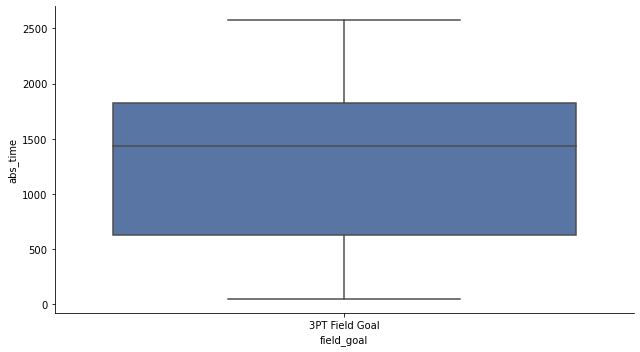

In [69]:
sns.catplot(data=shotsGame, kind='box', x='field_goal', y='abs_time', aspect=1.8, palette ='deep')

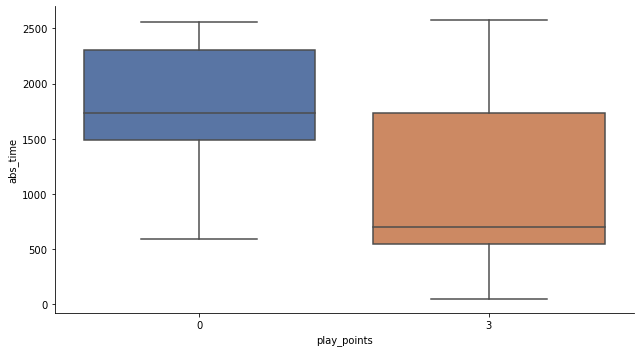

In [70]:
sns.catplot(data=shotsGame, kind='box', x='play_points', y='abs_time', aspect=1.8, palette ='deep')

___________________________

### Some simple EDA on Keldon's first game:

In [71]:
df_almostthere

,win_probability,play_description,abs_time,player_id,player,team_id,team,period,shot_result,shot_type,field_goal,distance,LOC_X,LOC_Y,location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
game_id,,,,,,,,,,,,,,,,,,,,,,
22100986,0.60163,Beasley 24' 3PT Step Back Jump Shot (3 PTS) (R...,48.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,24,232,75,R Below Break/Corner,Home,1,3,3,1,1,1.00
22100986,0.59959,Beasley 25' 3PT Step Back Jump Shot (6 PTS) (T...,408.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,24,38,243,R Above Break,Home,1,3,6,2,2,1.00
22100986,0.59926,Beasley 25' 3PT Jump Shot (9 PTS) (Russell 2 AST),466.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Jump Shot,3PT Field Goal,24,56,242,Center,Home,1,3,9,3,3,1.00
22100986,0.64628,MISS Beasley 25' 3PT Pullup Jump Shot,595.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Missed,Pullup Jump shot,3PT Field Goal,24,211,134,L Below Break/Corner,Home,2,0,9,4,3,0.75
22100986,0.68915,Beasley 3PT Running Jump Shot (12 PTS) (McLaug...,626.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Running Jump Shot,3PT Field Goal,22,-225,9,L Above Break,Home,5,3,12,5,4,0.80
22100986,0.75254,Beasley 25' 3PT Step Back Jump Shot (15 PTS),666.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,24,-65,237,R Center,Home,8,3,15,6,5,0.83
22100986,0.80892,Beasley 24' 3PT Step Back Jump Shot (18 PTS) (...,704.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Made,Step Back Jump shot,3PT Field Goal,23,-232,61,L Above Break,Home,11,3,18,7,6,0.86
22100986,0.96064,Beasley 3PT Jump Shot (21 PTS) (Russell 4 AST),1239.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Made,Jump Shot,3PT Field Goal,22,-224,-11,L Above Break,Home,21,3,21,8,7,0.88
22100986,0.98494,MISS Beasley 26' 3PT Step Back Jump Shot,1439.0,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Missed,Step Back Jump shot,3PT Field Goal,26,181,187,L Below Break/Corner,Home,25,0,21,9,7,0.78


In [72]:
df_almostthere.describe()

,win_probability,abs_time,player_id,team_id,period,distance,LOC_X,LOC_Y,score_margin,play_points,points,shots_taken,shots_hit,game_pct
count,17.000000,17.000000,17.0,1.700000e+01,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.859526,1362.294118,1627736.0,1.610613e+09,2.294118,24.294118,-69.470588,143.705882,17.411765,1.941176,19.764706,9.000000,6.588235,0.789412
std,0.170583,842.447978,0.0,0.000000e+00,1.263166,1.358524,179.831907,80.294586,11.890431,1.477777,9.371029,5.049752,3.123676,0.122804
min,0.599260,48.000000,1627736.0,1.610613e+09,1.000000,22.000000,-232.000000,-11.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.620000
25%,0.689150,626.000000,1627736.0,1.610613e+09,1.000000,24.000000,-224.000000,75.000000,5.000000,0.000000,12.000000,5.000000,4.000000,0.700000
50%,0.984940,1439.000000,1627736.0,1.610613e+09,2.000000,24.000000,-169.000000,163.000000,25.000000,3.000000,21.000000,9.000000,7.000000,0.750000
75%,0.994990,1828.000000,1627736.0,1.610613e+09,3.000000,25.000000,56.000000,193.000000,27.000000,3.000000,27.000000,13.000000,9.000000,0.860000
max,0.999110,2574.000000,1627736.0,1.610613e+09,4.000000,27.000000,232.000000,243.000000,30.000000,3.000000,33.000000,17.000000,11.000000,1.000000


In [73]:
df_almostthere.isnull().sum()

win_probability     0
play_description    0
abs_time            0
player_id           0
player              0
team_id             0
team                0
period              0
shot_result         0
shot_type           0
field_goal          0
distance            0
LOC_X               0
LOC_Y               0
location            0
player_h_v          0
score_margin        0
play_points         0
points              0
shots_taken         0
shots_hit           0
game_pct            0
dtype: int64

In [74]:
df_almostthere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 22100986 to 22100986
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   win_probability   17 non-null     float64
 1   play_description  17 non-null     object 
 2   abs_time          17 non-null     float64
 3   player_id         17 non-null     int64  
 4   player            17 non-null     object 
 5   team_id           17 non-null     int64  
 6   team              17 non-null     object 
 7   period            17 non-null     int64  
 8   shot_result       17 non-null     object 
 9   shot_type         17 non-null     object 
 10  field_goal        17 non-null     object 
 11  distance          17 non-null     int64  
 12  LOC_X             17 non-null     int64  
 13  LOC_Y             17 non-null     int64  
 14  location          17 non-null     object 
 15  player_h_v        17 non-null     object 
 16  score_margin      17 non-null    

#### If I drop nulls I drop the whole df for this game, as there are only 17 rows here.

No handles with labels found to put in legend.


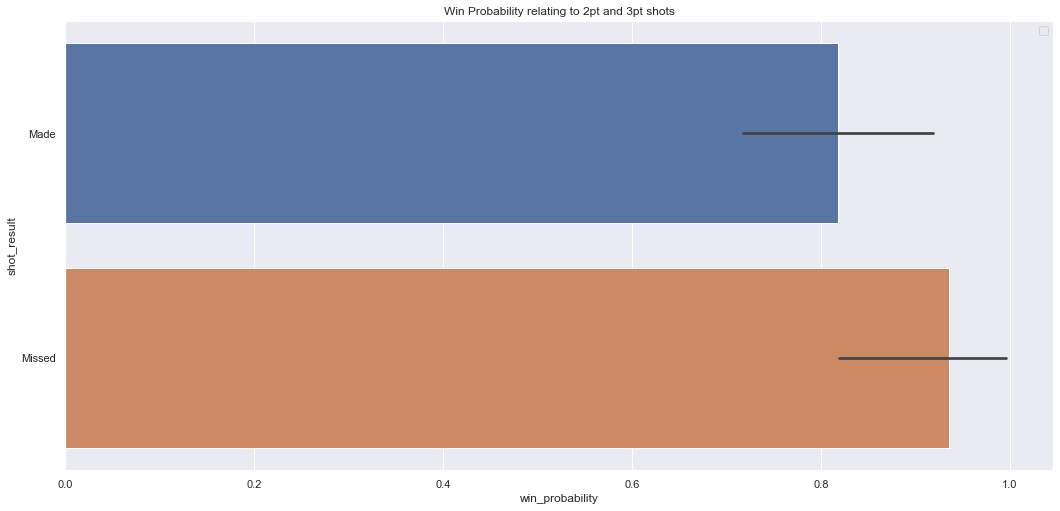

In [82]:
plt.title("Win Probability relating to 2pt and 3pt shots")
sns.barplot(x="win_probability", y="shot_result", data=df_almostthere)

plt.legend()
plt.show()

No handles with labels found to put in legend.


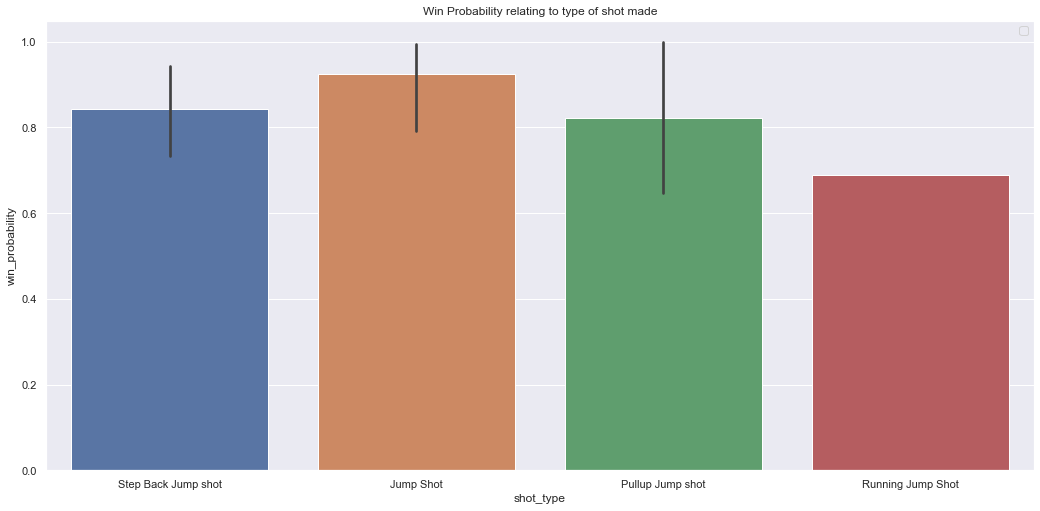

In [76]:
sns.set(rc={'figure.figsize':(17.7,8.27)})
plt.title("Win Probability relating to type of shot made")
sns.barplot(x="shot_type", y="win_probability", data=df_almostthere)
plt.legend()
plt.show()

In [77]:
#function from  Savvas Tjortjoglou of how to create an NBA sized court:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

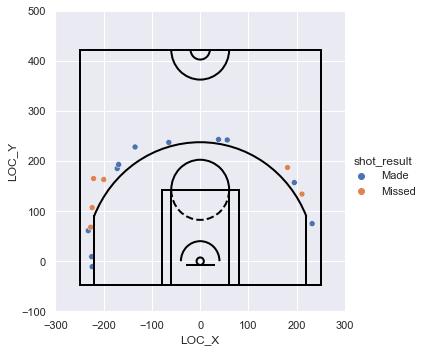

In [78]:
g=sns.relplot(data=df_almostthere.field_goal, kind = 'scatter',
               x = df_almostthere.LOC_X, y= df_almostthere.LOC_Y, hue= df_almostthere.shot_result)

for i, ax in enumerate(g.axes.flat):
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300, 300)
    ax.set_ylim(-100, 500)

In [79]:
#df_almostthere['in_game_time'] = for i in range(len(zipped)-1):
    #zipped[i+1][0] - zipped[i][1]

SyntaxError: invalid syntax (1045757615.py, line 1)

__________________________